# TikTok - Market Research (25 Publicly Traded Consumer Tech Companies)

![front_page](images/tiktok_grass.jpg)

Hello team, by way of introduction, my name is David. Many people call me World Peace (lol), but I think that's a topic for another time. I've grown very interested in TikTok's business model over the past few days as I started using the app myself. This whole project takes a user's persepective to look TikTok's monetization strategy and valuation. But because TikTok is not a public company, all the information I could gather are leaked. So by default, there is a ton of risk that they might not be correct at all. So I wanted to provide this data science (although more EDA than modeling) as a basis of some of the assumptions that I made.

Whenever I have a question or concern, I turn to the market for answer. Of course the market is not alwways rational and companies within the same industry could have very different business models, or at least very different approaches to running their business. This is very obvious if you take a look in the case studies in the presentation.

But I do believe the market in the aggregate is genearlly correct. In other words, the law of large numbers work in our favor when looking and positioning companies to a speciific number. I think it's reasonable that with enough internal data, we can have a reasonable debate on where those number sit in the industry spectrum. But I'm working with my own understanding on leaked numbers. So hopefully we could start that debate some time in the future.

Long story short, in this notebook, I essentially created a poor man's version of Capital IQ (expensive, expensive, expensive). Well, at least for my reasearch purposes. I chose 25 publicly traded companies listing across Hong Kong and the United States, both Chinese firms and US-based companies. I want to look at generally how these companies colletively generate revenue/profits and how they collectively spend money, which will inform the assumptions in my model.

I created an algorithm where the function would act like a real person to open the browser and look through the income statement of all 25 companies in [Yahoo Finance](https://finance.yahoo.com/). Here is an [example](https://finance.yahoo.com/quote/FB/financials?p=FB) of one of those pages (Facebook). I created a function so that the only I need to do is pass a list of company tickers and we should have the results in no time. I will provide further explainations as in the body of this project.

# Import Libraries

Here are the libraries we will need:
1. Pandas
2. Numpy
3. Sleep Functions (so that Yahoo doesn't find out that I'm scraping)
4. Graphing tools (matplotlib and seaborn)
5. Selenium (browser control)

In [7]:
import pandas as pd
import numpy as np
from time import sleep
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from selenium import webdriver

from webdriver_manager.chrome import ChromeDriverManager

# 25 Companies Reseached & User Counts

This is the list of the 25 companies that would be a part of this research. They are all consumer-facing technology companies (at least a large part) with different business models and monetization strategies. Here, we collect their name, ticker and user counts.
1. Amazon (AMZN)
2. Google (GOOG)
3. Facebook (FB)
4. Netflix (NFLX)
5. Snap (SNAP)
6. Twitter (TWTR)
7. Pinterst (PINS)
8. Uber (UBER)
9. Lyft (LYFT)
10. 腾讯 (0700.HK)
11. 百度 (BIDU)
12. 阿里巴巴 (BABA)
13. 哔哩哔哩 (BILI)
14. Spotify (SPOT)
15. Wayfair (W)
16. Grubhub (GRUB)
17. Intuit (INTU)
18. 爱奇艺 (IQ)
19. Zillow (Z)
20. 58同城 (WUBA)
21. Wix (WIX)
22. Dropbox (DBX)
23. 腾讯音乐 (TME)
24. Roku (ROKU)
25. 微博 (WB)

In [8]:
# Create a dictionary to map user counts with company ticker.
company_dict = {'AMZN':197,
                'GOOG':2000,
                'FB':2890,
                'NFLX':167,
                'SNAP':398,
                'TWTR':386,
                'PINS':335,
                'UBER':111,
                'LYFT':23,
                '0700.HK':1165,
                'BIDU':1100,
                'BABA':846,
                'BILI':130,
                'SPOT':271,
                'W':20,
                'GRUB':23,
                'INTU':37,
                'IQ':500,
                'Z':172,
                'WUBA':75,
                'WIX':165,
                'DBX':600,
                'TME':700,
                'ROKU':40,
                'WB':516}

In [160]:
# Create a list of company tickers.
company_list = list(company_dict.keys())

# Design Functions to Collect Income Statements for 25 Companies

First, create a function that scrapes one income statement based on the stock ticker on Yahoo Finance. This function will be the basis of our aggregated function. In a nutshell, we are:
1. Creating browser page that navigates the income statement page on Yahoo Fiannce
2. Expand on the rows (some are collapsed and hidden)
3. Go row by row to get the data and save them in a DataFrame.

![facebook](images/facebook.png)

In [10]:
def get_income_statement(ticker, driver):

    # Create income statement URL for each company
    url = 'https://finance.yahoo.com/quote/' + ticker + '/financials?p=' + ticker
    driver.get(url)
    sleep(np.random.choice([14,15,16,17]))

    # Click the expand button and find the table with multiple rows.
    driver.find_element_by_xpath("//span[contains(text(), 'Expand All')]").click()
    table_rows = driver.find_elements_by_xpath("//div[contains(@class, 'D(tbr)')]")
    assert len(table_rows) > 0

    # Set up a list to hold the rows.
    parsed_rows = []

    # Go around each table row, and pull out every item in each row.
    for row in range(len(table_rows)):
        parsed_row = []
        el = table_rows[row].find_elements_by_xpath("./div")
        for rs in el:
            if rs.text in ('-',):
                parsed_row.append(np.NaN)
            else:
                parsed_row.append(rs.text)

        # Append the row to the list we created.
        parsed_rows.append(parsed_row)

    # Create new DataFrame for each company.
    df = pd.DataFrame(parsed_rows)
    df = df.set_index(0).T
    df.insert(1, 'Ticker', ticker)
    name = driver.find_element_by_xpath("//h1[contains(@class, 'D(ib)')]").text
    index = driver.find_element_by_xpath("//h1[contains(@class, 'D(ib)')]").text.index('(')
    df.insert(2, 'Company', name[:index-1])
    
    return df

Leveraging the function for one company, we can effectively loop through a list of company tickers and get them all. This is our next function.

In [11]:
def get_income_statements(company_list):
    
    # Create an empty dictionary to hold the DataFrames.
    df_dict = {}
    error_1 = []
    error_2 = []
    error_3 = []
    success = []
    
    # Start with a Chrome Driver.
    driver = webdriver.Chrome(ChromeDriverManager().install())
    
    for company in company_list:
        try:
            df = get_income_statement(company, driver)
            df_dict[company] = df
            success.append(company)
        except Exception as e:
            print("Failed:", company, type(e))
            error_1.append(company)
    
    # There could be server-side detection to stop the scrapping.
    # This is the second try on those items.
    if len(error_1) > 0:
        print('----------')
        print('Now we are trying a 2nd round to capture the error items.')
        
        for company in error_1:
            try:
                df = get_income_statement(company, driver)
                df_dict[company] = df
                success.append(company)
            except Exception as e:
                print("Failed:", company, type(e))
                error_2.append(company)
    
    # Let's go another round with the same thing.
    if len(error_2) > 0:
        print('----------')
        print('Now we are trying a 2nd round to capture the error items.')
        
        for company in error_2:
            try:
                df = get_income_statement(company, driver)
                df_dict[company] = df
                success.append(company)
            except Exception as e:
                print("Failed:", company, type(e))
                error_3.append(company)
    
    # Let's Summarize
    if len(error_3) > 0:
        print('Successful scrape for the following companies:', success)
        print('Failed to scrape the following companies:', error_3)
    else:
        print("Complete!")
    
    return df_dict

# Collect the Data

Now we collect the data. Due to the sleeps in the middle, this took roughly 5 minues.

In [12]:
df_dict = get_income_statements(company_list)

Trying to download new driver from http://chromedriver.storage.googleapis.com/83.0.4103.39/chromedriver_mac64.zip
Unpack archive /Users/guoningli/.wdm/drivers/chromedriver/83.0.4103.39/mac64/chromedriver.zip
Complete!


In [168]:
# Akl data scraped.
df_dict.keys()

dict_keys(['AMZN', 'GOOG', 'FB', 'NFLX', 'SNAP', 'TWTR', 'PINS', 'UBER', 'LYFT', '0700.HK', 'BIDU', 'BABA', 'BILI', 'SPOT', 'W', 'GRUB', 'INTU', 'IQ', 'Z', 'WUBA', 'WIX', 'DBX', 'TME', 'ROKU', 'WB'])

# Data Cleaning

## Concat DataFrame

First thing we need to do is to concat the DataFrames. We have a dictionary of 25 DataFrames and we need to perform our manipulations on one single table.

In [14]:
df_raw = pd.DataFrame()

for v in df_dict.values():
    df_raw = pd.concat([df_raw, v], sort=False)

In [15]:
df_raw.shape

(124, 67)

In [24]:
df_raw.columns

Index(['Breakdown', 'Ticker', 'Company', 'Total Revenue', 'Operating Revenue',
       'Cost of Revenue', 'Gross Profit', 'Operating Expense',
       'Selling General and Administrative',
       'General & Administrative Expense', 'Other G and A',
       'Selling & Marketing Expense', 'Research & Development',
       'Other Operating Expenses', 'Operating Income',
       'Net Non Operating Interest Income Expense',
       'Interest Income Non Operating', 'Interest Expense Non Operating',
       'Other Income Expense', 'Gain on Sale of Security',
       'Other Non Operating Income Expenses', 'Pretax Income', 'Tax Provision',
       'Earnings from Equity Interest Net of Tax',
       'Net Income Common Stockholders', 'Net Income',
       'Net Income Including Non-Controlling Interests',
       'Net Income Continuous Operations',
       'Diluted NI Available to Com Stockholders', 'Basic EPS', 'Diluted EPS',
       'Basic Average Shares', 'Diluted Average Shares',
       'Total Operating Inc

## Save to CSV

In [23]:
df_raw.to_csv('./tiktok.csv')

In [18]:
df_raw.head()

,Breakdown,Ticker,Company,Total Revenue,Operating Revenue,Cost of Revenue,Gross Profit,Operating Expense,Selling General and Administrative,General & Administrative Expense,...,Depreciation Amortization Depletion,Depreciation & amortization,Gain on Sale of Business,Minority Interests,Amortization,Amortization of Intangibles,Restructuring & Mergers Acquisition,Impairment of Capital Assets,Preferred Stock Dividends,Write Off
1,TTM,AMZN,"Amazon.com, Inc.","296,274,000","296,274,000","219,035,000","77,239,000","63,129,000","25,524,000","5,482,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12/31/2019,AMZN,"Amazon.com, Inc.","280,522,000","280,522,000","205,768,000","74,754,000","60,213,000","24,081,000","5,203,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12/31/2018,AMZN,"Amazon.com, Inc.","232,887,000","232,887,000","173,183,000","59,704,000","47,283,000","18,150,000","4,336,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12/31/2017,AMZN,"Amazon.com, Inc.","177,866,000","177,866,000","137,183,000","40,683,000","36,577,000","13,743,000","3,674,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,12/31/2016,AMZN,"Amazon.com, Inc.","135,987,000","135,987,000","105,884,000","30,103,000","25,917,000","9,665,000","2,432,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create a DataFrame for TTM
These trailing 12 month numbers might be helpful, keep them for in a separate DataFrame for now.

In [20]:
df_ttm = df_raw.loc[df_raw['Breakdown']=='TTM']

In [21]:
df_ttm.head()

,Breakdown,Ticker,Company,Total Revenue,Operating Revenue,Cost of Revenue,Gross Profit,Operating Expense,Selling General and Administrative,General & Administrative Expense,...,Depreciation Amortization Depletion,Depreciation & amortization,Gain on Sale of Business,Minority Interests,Amortization,Amortization of Intangibles,Restructuring & Mergers Acquisition,Impairment of Capital Assets,Preferred Stock Dividends,Write Off
1,TTM,AMZN,"Amazon.com, Inc.","296,274,000","296,274,000","219,035,000","77,239,000","63,129,000","25,524,000","5,482,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TTM,GOOG,Alphabet Inc.,"166,677,000","165,686,000","74,866,000","91,811,000","56,211,000","29,402,000","10,343,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TTM,FB,"Facebook, Inc.","73,357,000","72,183,000","13,413,000","59,944,000","33,382,000","18,627,000","7,984,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TTM,NFLX,"Netflix, Inc.","21,403,146","21,403,146","13,169,300","8,233,846","5,130,420","3,504,218","964,504",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TTM,SNAP,Snap Inc.,"1,857,586","1,857,586","945,481","912,105","1,985,736","1,079,799","596,878",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Create DataFrame for Most Recent 10K (2019)

Since we collected 4 years of data for each company, there are too many rows. Since we won't really be assessing the growth rate, so there is really no reason to keep the previous reports. We only need the most recent income statement.

In [28]:
# Take out TTM numbers.
df_clean = df_raw.loc[df_raw['Breakdown'] != 'TTM']

In [29]:
# Turn date texts to date types.
df_clean['Breakdown'] = pd.to_datetime(df_clean['Breakdown'])

/Users/guoningli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
# Turn number texts to numbers.
for col in list(df_clean.columns)[3:]:
    df_clean[col] = df_clean[col].str.replace(',','')
    df_clean[col] = df_clean[col].astype(np.float64)

/Users/guoningli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/guoningli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
# Keep only the most recent row for each company.
df_recent = df_clean.sort_values(['Ticker', 'Breakdown'], ascending=[True, True]).groupby('Ticker').tail(1)

## Do Some Additional Cleaning

![clean](images/clean.jpg)

1. Get a simpler DataFrame with only the columns we need.
2. Numbers currently in thousands: turn thousands to millions.
3. Tencent is based in HKD: turn Tencent currecy to USD using current exchange rate.
4. Add user counts.
5. The company names are too "legal": clean the names to make them shorter.

### I. Get Rid of Unrelated Columns
First, let's check for nulls. Keep in mind we don't need all the numbers here, just operating expenses, revenue and profits.

In [48]:
# Check for nulls.
# Seems like for the values we need, we are good to go.
df_recent.isnull().sum().head(30)

Breakdown                                          0
Ticker                                             0
Company                                            0
Total Revenue                                      0
Operating Revenue                                  0
Cost of Revenue                                    0
Gross Profit                                       0
Operating Expense                                  0
Selling General and Administrative                 0
General & Administrative Expense                   2
Other G and A                                      3
Selling & Marketing Expense                        2
Research & Development                             4
Other Operating Expenses                          20
Operating Income                                   0
Net Non Operating Interest Income Expense          0
Interest Income Non Operating                      5
Interest Expense Non Operating                     5
Other Income Expense                          

In [50]:
# Create a smaller DataFrame for ease of eyes.
df_recent = df_recent[['Ticker', 'Company', 'Total Revenue', 'Cost of Revenue', 'Operating Expense', 'Selling General and Administrative', 'Selling & Marketing Expense','Research & Development', 'Operating Income','Net Income']]

In [53]:
df_recent.head()

,Ticker,Company,Total Revenue,Cost of Revenue,Operating Expense,Selling General and Administrative,Selling & Marketing Expense,Research & Development,Operating Income,Net Income
2,0700.HK,Tencent Holdings Limited,377289000.0,209756000.0,70961000.0,74842000.0,21396000.0,NaN,96572000.0,93310000.0
2,AMZN,"Amazon.com, Inc.",280522000.0,205768000.0,60213000.0,24081000.0,18878000.0,35931000.0,14541000.0,11588000.0
2,BABA,Alibaba Group Holding Limited,509711000.0,282367000.0,135338000.0,78870000.0,50673000.0,43080000.0,92006000.0,149433000.0
2,BIDU,"Baidu, Inc.",107413000.0,62850000.0,38256000.0,19910000.0,NaN,18346000.0,6307000.0,2057000.0
2,BILI,Bilibili Inc.,6777922.0,5587673.0,2685424.0,1791013.0,1198516.0,894411.0,-1495175.0,-1288973.0


### II. Numbers in Millions

These numbers are currently in thousands (of dollars), but the unit of our user base is millions. So let's get rid of some zeors.

In [77]:
df_recent.loc[:,'Total Revenue' :] = df_recent.loc[:,'Total Revenue' :] / 1_000

/Users/guoningli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [79]:
df_recent.head()

,Ticker,Company,Total Revenue,Cost of Revenue,Operating Expense,Selling General and Administrative,Selling & Marketing Expense,Research & Development,Operating Income,Net Income
2,0700.HK,Tencent Holdings Limited,377289.000,209756.000,70961.000,74842.000,21396.000,NaN,96572.000,93310.000
2,AMZN,"Amazon.com, Inc.",280522.000,205768.000,60213.000,24081.000,18878.000,35931.000,14541.000,11588.000
2,BABA,Alibaba Group Holding Limited,509711.000,282367.000,135338.000,78870.000,50673.000,43080.000,92006.000,149433.000
2,BIDU,"Baidu, Inc.",107413.000,62850.000,38256.000,19910.000,NaN,18346.000,6307.000,2057.000
2,BILI,Bilibili Inc.,6777.922,5587.673,2685.424,1791.013,1198.516,894.411,-1495.175,-1288.973


### III. Change Tencent Exchange Rate From HKD to USD
Tencent is traded in Hong Kong and therefore uses HKD as their measurement of accounting. We need to turn this number to USD.

In [82]:
usd_hkd_fx = 7.75
df_recent.loc[df_recent['Ticker']=='0700.HK', 'Total Revenue':] = df_recent.loc[df_recent['Ticker']=='0700.HK', 'Total Revenue':] / usd_hkd_fx

In [83]:
df_recent.head()

,Ticker,Company,Total Revenue,Cost of Revenue,Operating Expense,Selling General and Administrative,Selling & Marketing Expense,Research & Development,Operating Income,Net Income
2,0700.HK,Tencent Holdings Limited,48682.451613,27065.290323,9156.258065,9657.032258,2760.774194,NaN,12460.903226,12040.000
2,AMZN,"Amazon.com, Inc.",280522.000000,205768.000000,60213.000000,24081.000000,18878.000000,35931.000,14541.000000,11588.000
2,BABA,Alibaba Group Holding Limited,509711.000000,282367.000000,135338.000000,78870.000000,50673.000000,43080.000,92006.000000,149433.000
2,BIDU,"Baidu, Inc.",107413.000000,62850.000000,38256.000000,19910.000000,NaN,18346.000,6307.000000,2057.000
2,BILI,Bilibili Inc.,6777.922000,5587.673000,2685.424000,1791.013000,1198.516000,894.411,-1495.175000,-1288.973


### IV. Add User Counts

In [85]:
df_recent.insert(2, 'Users', df_recent['Ticker'].map(company_dict))

In [99]:
df_recent.head()

,Ticker,Company,Users,Total Revenue,Cost of Revenue,Operating Expense,Selling General and Administrative,Selling & Marketing Expense,Research & Development,Operating Income,Net Income
2,0700.HK,Tencent,1165,48682.451613,27065.290323,9156.258065,9657.032258,2760.774194,NaN,12460.903226,12040.000
2,AMZN,Amazon.com,197,280522.000000,205768.000000,60213.000000,24081.000000,18878.000000,35931.000,14541.000000,11588.000
2,BABA,Alibaba Group,846,509711.000000,282367.000000,135338.000000,78870.000000,50673.000000,43080.000,92006.000000,149433.000
2,BIDU,Baidu,1100,107413.000000,62850.000000,38256.000000,19910.000000,NaN,18346.000,6307.000000,2057.000
2,BILI,Bilibili,130,6777.922000,5587.673000,2685.424000,1791.013000,1198.516000,894.411,-1495.175000,-1288.973


### V. Clean Company Names

In [94]:
def company_name_clean(name):
    name.strip()
    if name.endswith(' Holdings Limited'):
        return name[:-17]
    elif name.endswith(', Inc.'):
        return name[:-6]
    elif name.endswith(' Inc.'):
        return name[:-5]
    elif name.endswith(' Holding Limited'):
        return name[:-16]
    elif name.endswith('Technologies S.A.'):
        return name[:-17]
    elif name.endswith(' Group'):
        return name[:-6]
    elif name.endswith(' Corporation'):
        return name[:-12]
    elif name.endswith(' Ltd.'):
        return name[:-5]
    else:
        return name

In [96]:
df_recent['Company'] = df_recent['Company'].apply(company_name_clean)

/Users/guoningli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [98]:
df_recent.head()

,Ticker,Company,Users,Total Revenue,Cost of Revenue,Operating Expense,Selling General and Administrative,Selling & Marketing Expense,Research & Development,Operating Income,Net Income
2,0700.HK,Tencent,1165,48682.451613,27065.290323,9156.258065,9657.032258,2760.774194,NaN,12460.903226,12040.000
2,AMZN,Amazon.com,197,280522.000000,205768.000000,60213.000000,24081.000000,18878.000000,35931.000,14541.000000,11588.000
2,BABA,Alibaba Group,846,509711.000000,282367.000000,135338.000000,78870.000000,50673.000000,43080.000,92006.000000,149433.000
2,BIDU,Baidu,1100,107413.000000,62850.000000,38256.000000,19910.000000,NaN,18346.000,6307.000000,2057.000
2,BILI,Bilibili,130,6777.922000,5587.673000,2685.424000,1791.013000,1198.516000,894.411,-1495.175000,-1288.973


## Data Analysis
![data](images/data.jpg)

Again, the rationale behind these analysis are 2 things:
1. **Law of Large Numbers**: With a sample of 25 consumer tech companies, the law of large numbers should work in our favor pretty substantially. Of course I would want more companies, but I think I could live with 25 companies and sleep better at night than 0 companies. I will assume that the data presented by these 25 companies will colletively give me a good perspective of the spectrum and the average of the industry.
2. **Variation of Business Models**: It's important to recognize what each company does to moentize their business. For example, Amazon has a AWS arm that is completely unrelated to our research. So there are some variables to consider and think about how TikTok would fit in that spectrum.

### I. Cost of Revenue % Revenue (Row 11 in Excel Model)

Cost of revenue means different things for different companies. But by and large, they are variable costs that increase with the revenue. In the case of TikTok, more advertsing are driven by more users (therefore more cloud expenses and more support teams). I think because of the global nature of all consumer technology companies, I think it's reasonable to take a simple average here for TikTok.

In [102]:
df_1 = df_recent[['Company', 'Total Revenue', 'Cost of Revenue']]
df_1.head(3)

,Company,Total Revenue,Cost of Revenue
2,Tencent,48682.451613,27065.290323
2,Amazon.com,280522.000000,205768.000000
2,Alibaba Group,509711.000000,282367.000000


In [103]:
df_1['CoR_Pct'] = df_1['Cost of Revenue'] / df_1['Total Revenue']
df_1.head(3)

/Users/guoningli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Company,Total Revenue,Cost of Revenue,CoR_Pct
2,Tencent,48682.451613,27065.290323,0.555956
2,Amazon.com,280522.000000,205768.000000,0.733518
2,Alibaba Group,509711.000000,282367.000000,0.553975


In [106]:
df_1['CoR_Pct'].mean()

0.5061189297345124

### SG&A Per MAU (Row 12 in Excel Model)

As the platform aggregates more users on the platform, the marketing cost to maintain the brand name, advertising cost and corporate expenses should go up as well. So, the consumer technology market should provide a good rule of thumb to this number.

But for TikTok, I believe the network effect is stronger than the average consumer company. In other words, TikTok would spend less on SG&A as it gets to scale. For example, it takes Uber or GrubHub many coupons and discounts to get users on their platform. These coupons can get very expensive, thus boosting up the marketing and advertising expenses. TikTok is a very different story. The cost to acquire a new user should be flat or decreasing as it gets to scale. In addition, becasue a lot of the operations and uers are based in China, I would expect comps to be a little lower than US counterparts, which gives TikTok an advantage in SG&A expenses.

Therefore, I will use the **20th percentile** of the market "SG&A Per MAU" in my valuation.

In [109]:
df_2 = df_recent[['Company', 'Users', 'Selling General and Administrative', 'Selling & Marketing Expense']]

In [114]:
df_2['SGA_MAU_Pct'] = df_2['Selling General and Administrative']/df_2['Users']

/Users/guoningli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [129]:
df_2.head(3)

,Company,Users,Selling General and Administrative,Selling & Marketing Expense,SGA_MAU_Pct
2,Wayfair,20,3077.273,2720.546,153.863650
2,Amazon.com,197,24081.000,18878.000,122.238579
2,58.com,75,8866.964,8049.662,118.226187


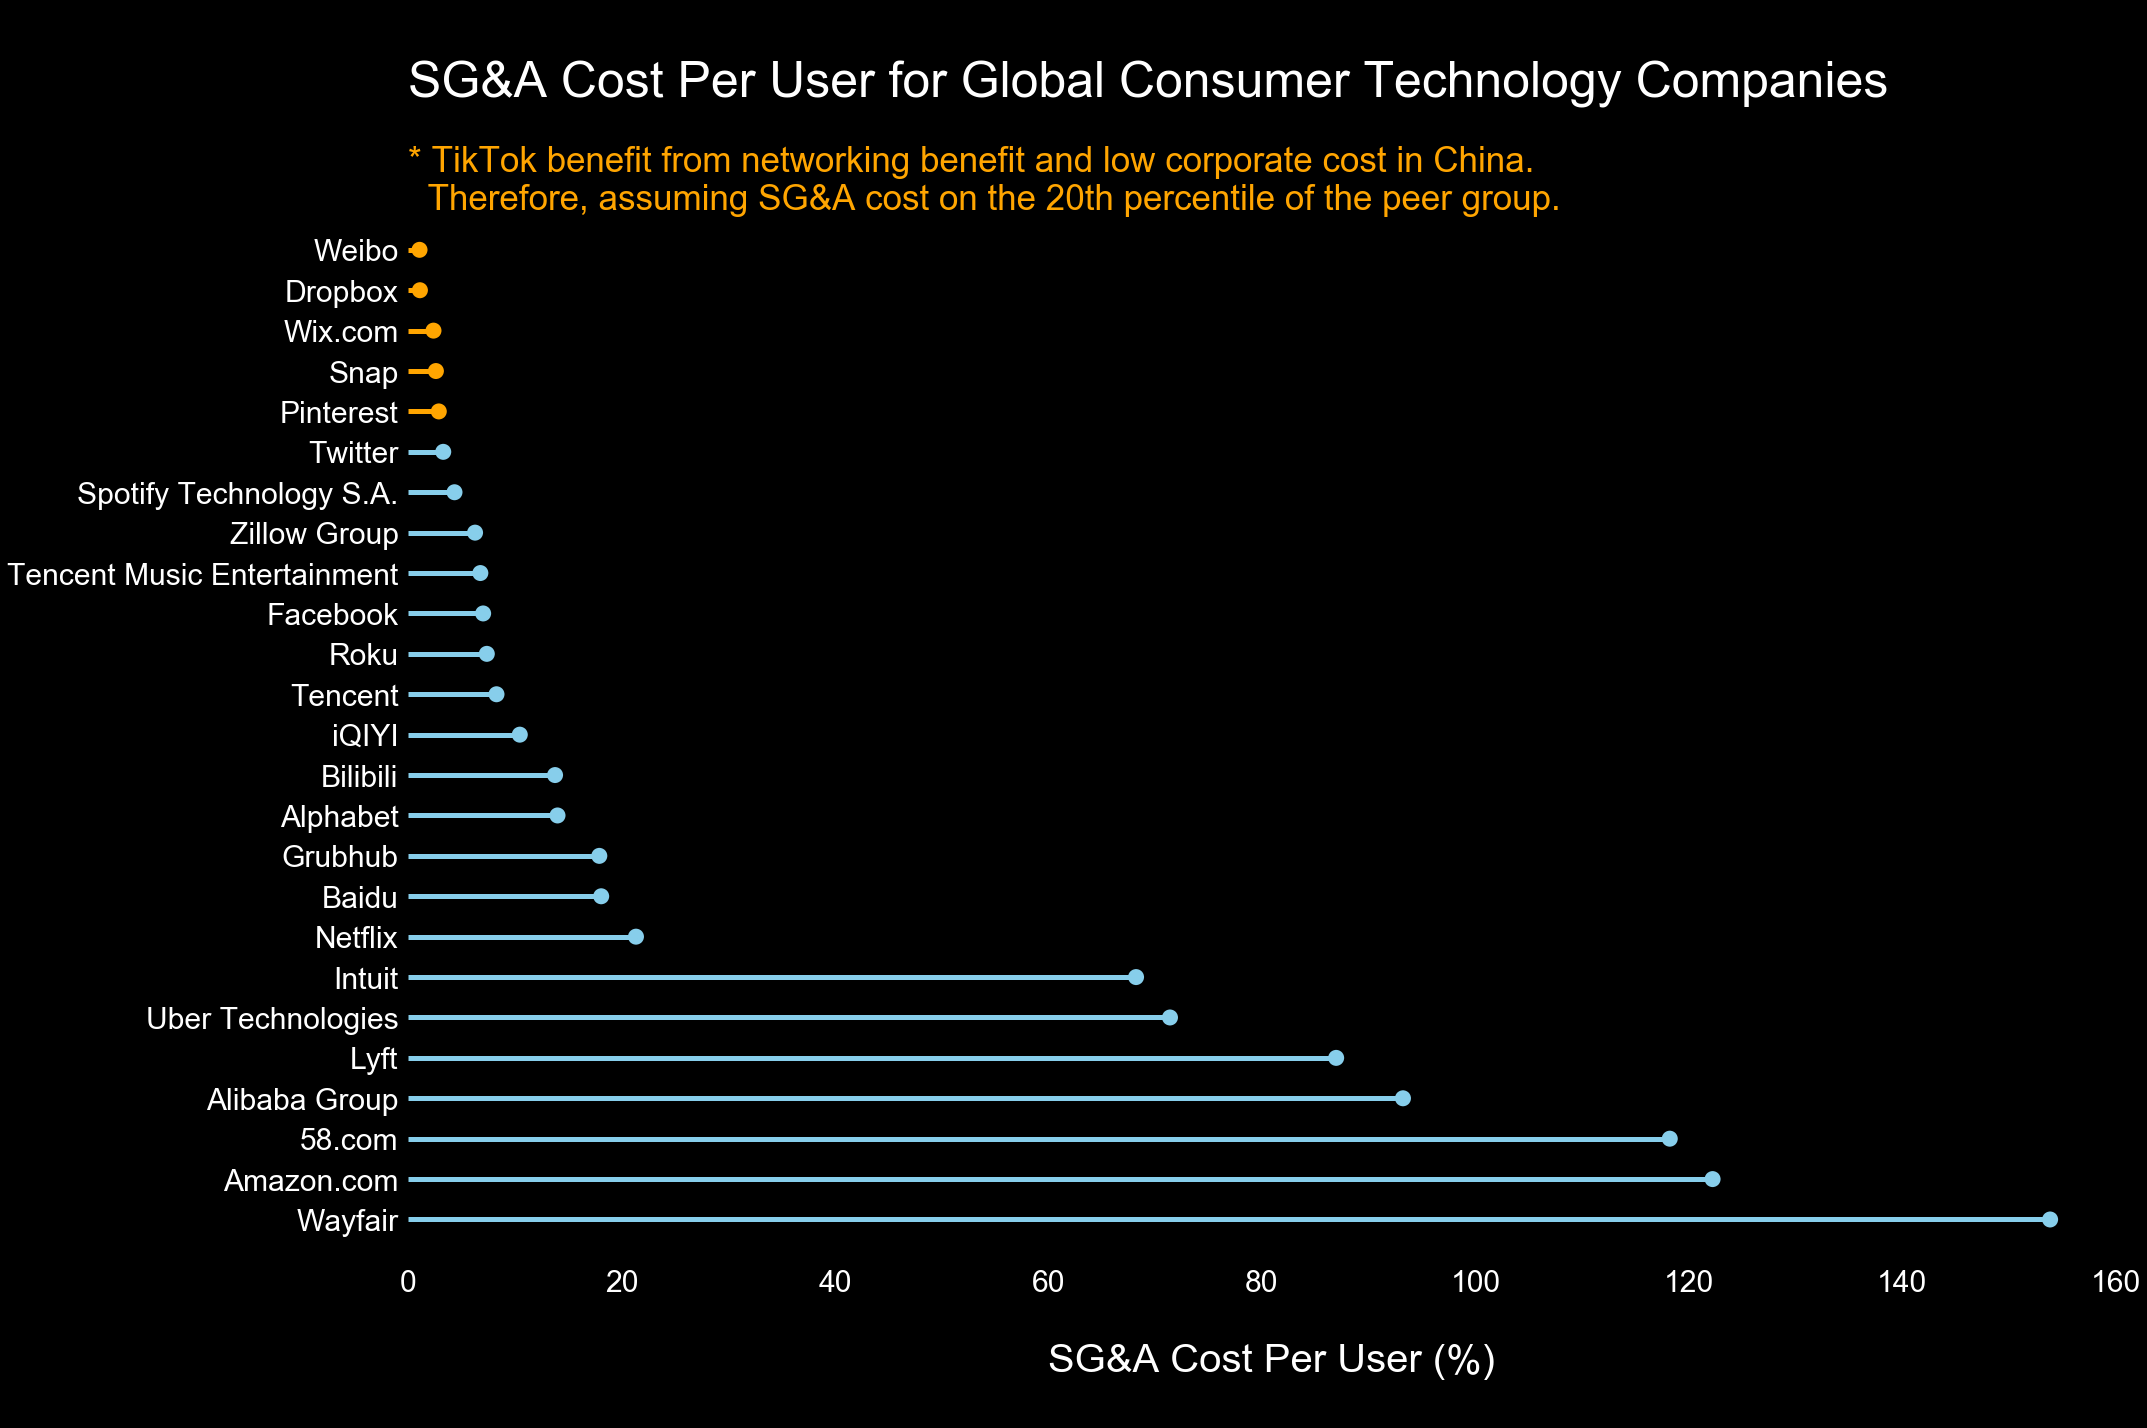

In [156]:
plt.style.use('dark_background')

# Get top 30 fastest growing SaaS stocks.
df_2 = df_2.sort_values('SGA_MAU_Pct', ascending=False)

my_range = range(1,26)
my_color = np.where((df_2.SGA_MAU_Pct <= df_2['SGA_MAU_Pct'].quantile(.2)), 'orange', 'skyblue')

fig, ax = plt.subplots(figsize=(30,20))

plt.hlines(y=my_range,
           xmin=0,
           xmax=df_2['SGA_MAU_Pct'],
           color=my_color,
           alpha=1,
           linewidth=5)

plt.scatter(x=df_2['SGA_MAU_Pct'],
            y=my_range,
            color=my_color,
            alpha=1,
            linewidth=10)

plt.ylim(bottom=0, top=26)
plt.xlim(left=0)

plt.yticks(my_range, df_2.Company)
plt.title("\nSG&A Cost Per User for Global Consumer Technology Companies\n\n",
          loc = 'left',
          fontsize = 50)
plt.xlabel('\nSG&A Cost Per User (%)\n', fontsize=40)
plt.ylabel('')
plt.text(0, 26, 
         '* TikTok benefit from networking benefit and low corporate cost in China.\n  Therefore, assuming SG&A cost on the 20th percentile of the peer group.',
         {'color':'orange', 'fontsize':35})

plt.grid(b=False)

ax.spines['top'].set_linewidth(.3)
ax.spines['left'].set_linewidth(.3)
ax.spines['right'].set_linewidth(.3)
ax.spines['bottom'].set_linewidth(.3)

sns.despine(top=True, right=True, left=True, bottom=True)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# plt.axvline(x=80, color='lightgrey', ymin=0.01, ymax=0.88, linestyle="--", linewidth=2)
# plt.axvline(x=60, color='lightgrey', ymin=0.01, ymax=0.70, linestyle="--", linewidth=2)
# plt.axvline(x=40, color='lightgrey', ymin=0.01, ymax=0.20, linestyle="--", linewidth=2)

plt.tight_layout()
plt.show();

In [167]:
df_2['SGA_MAU_Pct'].quantile(.25)

4.354243542435424

### R&D Per MAU (Row 16 in Excel Model)

Same rationale as above, I think it's fair to observe R&D numbers as a function of users. All else equal, companies with more users should be spending more on R&D, and it goes in the other direction as well. Given that most of the engineers and researchers at TikTok are based at mainland China, the cost of R&D should be a lot lower than US counterparts due to the comp advantage and longer weekly working hours in China.

Therefore, I will use the **25th percentile** of the market "R&D Per MAU" in my valuation.

In [137]:
df_3 = df_recent[['Company', 'Users', 'Research & Development']]

In [139]:
# 4 companies didn't report R&D numbers or aggregated it with other numbers.
# Getting rid of those 4 compnaies in our research.
df_3 = df_3.loc[df_3['Research & Development'].notnull()]

In [142]:
df_3['RnD_MAU'] = df_3['Research & Development'] / df_3['Users']
df_3.head()

,Company,Users,Research & Development,RnD_MAU
2,Amazon.com,197,35931.000,182.390863
2,Alibaba Group,846,43080.000,50.921986
2,Baidu,1100,18346.000,16.678182
2,Bilibili,130,894.411,6.880085
2,Dropbox,600,662.100,1.103500


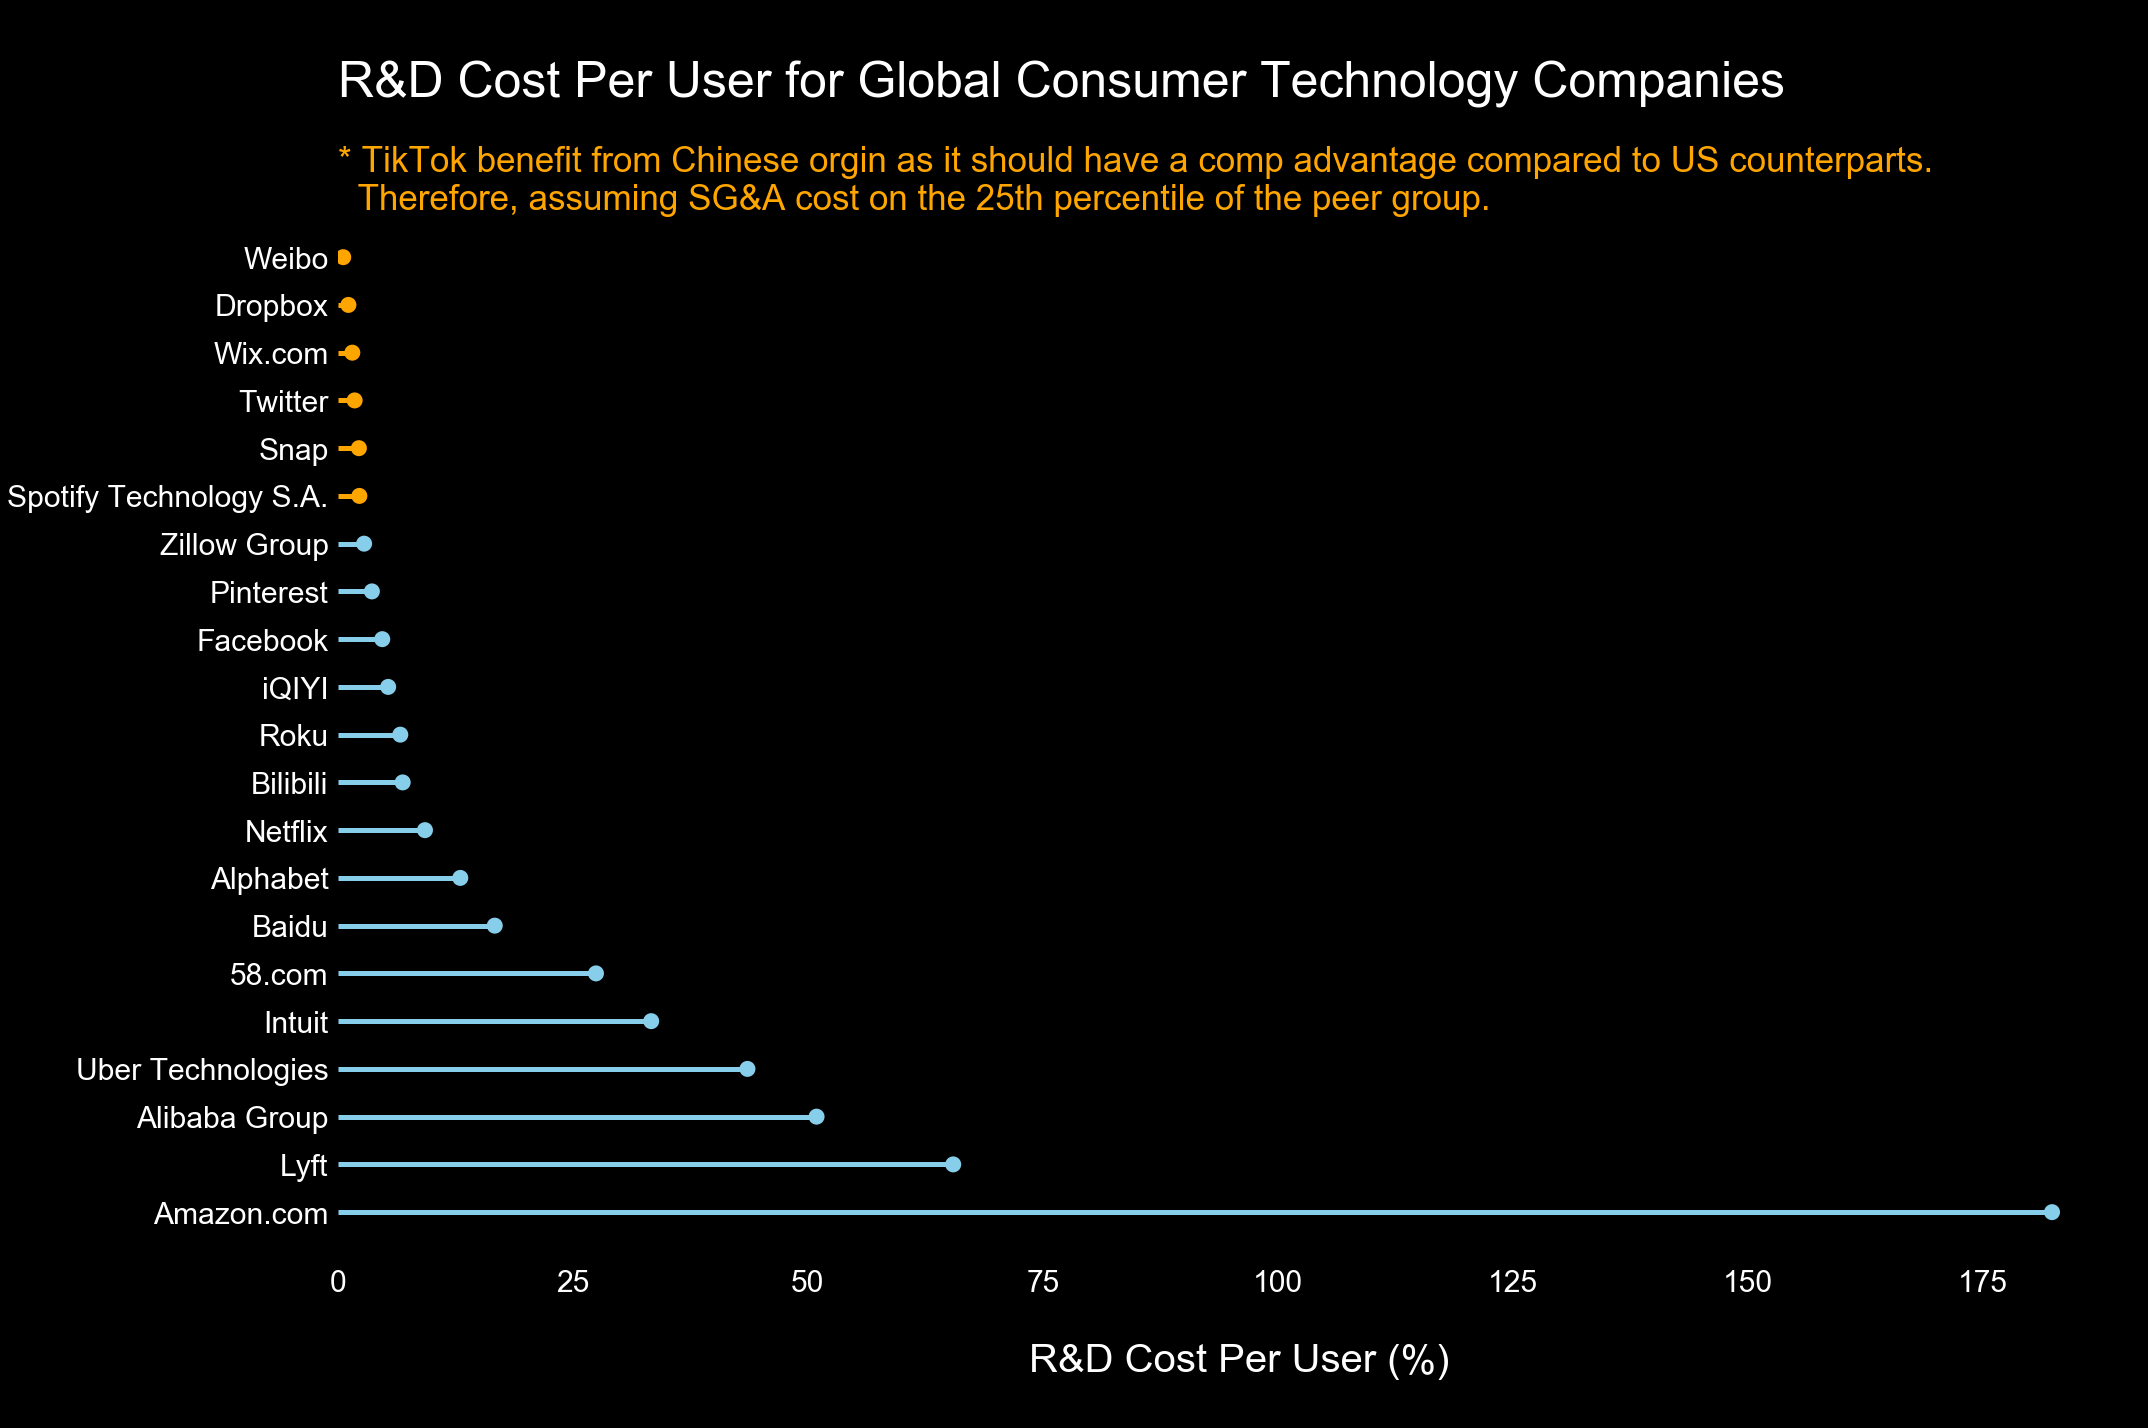

In [159]:
plt.style.use('dark_background')

# Get top 30 fastest growing SaaS stocks.
df_3 = df_3.sort_values('RnD_MAU', ascending=False)

my_range = range(1,22)
my_color = np.where((df_3.RnD_MAU <= df_3['RnD_MAU'].quantile(.25)), 'orange', 'skyblue')

fig, ax = plt.subplots(figsize=(30,20))

plt.hlines(y=my_range,
           xmin=0,
           xmax=df_3['RnD_MAU'],
           color=my_color,
           alpha=1,
           linewidth=5)

plt.scatter(x=df_3['RnD_MAU'],
            y=my_range,
            color=my_color,
            alpha=1,
            linewidth=10)

plt.ylim(bottom=0, top=22)
plt.xlim(left=0)

plt.yticks(my_range, df_3.Company)
plt.title("\nR&D Cost Per User for Global Consumer Technology Companies\n\n",
          loc = 'left',
          fontsize = 50)
plt.xlabel('\nR&D Cost Per User (%)\n', fontsize=40)
plt.ylabel('')
plt.text(0, 22, 
         '* TikTok benefit from Chinese orgin as it should have a comp advantage compared to US counterparts.\n  Therefore, assuming SG&A cost on the 25th percentile of the peer group.',
         {'color':'orange', 'fontsize':35})

plt.grid(b=False)

ax.spines['top'].set_linewidth(.3)
ax.spines['left'].set_linewidth(.3)
ax.spines['right'].set_linewidth(.3)
ax.spines['bottom'].set_linewidth(.3)

sns.despine(top=True, right=True, left=True, bottom=True)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# plt.axvline(x=80, color='lightgrey', ymin=0.01, ymax=0.88, linestyle="--", linewidth=2)
# plt.axvline(x=60, color='lightgrey', ymin=0.01, ymax=0.70, linestyle="--", linewidth=2)
# plt.axvline(x=40, color='lightgrey', ymin=0.01, ymax=0.20, linestyle="--", linewidth=2)

plt.tight_layout()
plt.show();

In [158]:
df_3['RnD_MAU'].quantile(.25)

2.2693726937269374